## Tracks ripple participation probability over epochs

In [1]:
%cd ..
import pandas as pd
import numpy as np 
import glob
import matplotlib.pyplot as plt

# import hdf5storage
# import h5py
# import scipy.io as sio

import sys,os
import seaborn as sns

import functions,loading

import nelpy as nel  # main nelpy imports
# import nelpy.plotting as npl  # optional plotting import

import math
import itertools
from scipy import stats
import multiprocessing
from joblib import Parallel, delayed
from scipy.ndimage import gaussian_filter1d
from sklearn.linear_model import LinearRegression
import matplotlib


d:\github\ripple_heterogeneity\python


C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\plotting\decoding.py:9: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.


In [2]:
tex_fonts = {
#     # Use LaTeX to write all text
#     "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "svg.fonttype": 'none'
}
plt.style.use('seaborn-paper')
# plt.style.use('dark_background')

plt.rcParams.update(tex_fonts)

# plt.rcParams['svg.fonttype'] = 'none'

%config InlineBackend.figure_format = 'retina'

fig_save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\project_log'

In [130]:
def compress_repeated_epochs(epoch_df):
    match = np.zeros([epoch_df.environment.shape[0]])
    match[match == 0] = np.nan
    for i,ep in enumerate(epoch_df.environment[:-1]):
        if np.isnan(match[i]):
            # find match in current and next epoch
            if ep == epoch_df.environment.iloc[i+1]:
                match[i:i+2] = i
                # given match, see if there are more matches
                for match_i in np.arange(1,epoch_df.environment[:-1].shape[0]):
                    if i+1+match_i == epoch_df.environment.shape[0]:
                        break
                    if ep == epoch_df.environment.iloc[i+1+match_i]:

                        match[i:i+1+match_i+1] = i
                    else:
                        break

    for i in range(len(match)):
        if np.isnan(match[i]):
            match[i] = (i+1)*2000 # make nans large numbers that are unlikely to be real epoch

    # iter through each epoch indicator to get start and stop
    results = pd.DataFrame()
    no_nan_match = match[~np.isnan(match)]
    for m in pd.unique(no_nan_match):
        temp_dict = {'name': epoch_df[match==m].name.iloc[0],
                    'startTime':epoch_df[match==m].startTime.iloc[0],
                    'stopTime':epoch_df[match==m].stopTime.iloc[-1],
                    'environment':epoch_df[match==m].environment.iloc[0],
                    'behavioralParadigm':epoch_df[match==m].behavioralParadigm.iloc[0],
    }
        temp_df = pd.DataFrame.from_dict(temp_dict,orient='index').T

        results = results.append(temp_df,ignore_index=True)
    return results
    
def load_basic_data(basepath):
    nChannels, fs, fs_dat, shank_to_channel = functions.loadXML(basepath)
    ripples = loading.load_ripples_events(basepath)
    cell_metrics,data = loading.load_cell_metrics(basepath)
    return cell_metrics,data,ripples,fs_dat

def get_participation(st,ripple_epochs):
    # get participation prob.
    # make matrix n rows (units) by n cols (ripple epochs)
    unit_mat = np.zeros((st.n_units,ripple_epochs.n_intervals))
    for i,event in enumerate(st):
        unit_mat[:,i] = (event.n_events>0)*1
    return unit_mat

def main_analysis(basepath,cell_metrics,st_unit,ripple_epochs,behavioral_epochs,epoch_df):

    # create empty dataframe to add metrics from each epoch
    df_save = pd.DataFrame()

    # create spike train object with ripple epochs
    st_unit_rip = st_unit[ripple_epochs]

    epochs = epoch_df.environment
    familiarity = epoch_df.behavioralParadigm

    for i,ep in enumerate(behavioral_epochs):
        temp_save = pd.DataFrame()

        unit_mat = get_participation(st_unit_rip[ep],
                                        ripple_epochs[ep])
        participation_prob = np.sum(unit_mat,axis=1) / unit_mat.shape[1]

        if participation_prob.shape[0] == 0:
            participation_prob = np.nan
            
        # package results and previously saved metrics
        temp_save['UID'] = cell_metrics.UID
        temp_save['basepath'] = basepath
        temp_save['epoch'] = epochs[i]
        temp_save['epoch_n'] = i
        temp_save['familiarity'] = familiarity[i]
        temp_save['deepSuperficial'] = cell_metrics.deepSuperficial
        temp_save['participation_prob'] = participation_prob

        df_save = df_save.append(temp_save,ignore_index=True)

    return df_save

def session_loop(basepath,save_path):
    save_file = os.path.join(save_path,basepath.replace(os.sep, "_").replace(":", "_")  + '.csv')
    if os.path.exists(save_file):
        return

    cell_metrics,data,ripples,fs_dat = load_basic_data(basepath)

    restrict_idx = ((cell_metrics.putativeCellType == "Pyramidal Cell") &
                        ((cell_metrics.brainRegion=="CA1") |
                        (cell_metrics.brainRegion=="rCA1") |
                        (cell_metrics.brainRegion=="lCA1")))

    # restrict cell metrics                      
    cell_metrics = cell_metrics[restrict_idx]
    
    if cell_metrics.shape[0] == 0:
        return

    # get ripple epochs
    ripple_epochs = nel.EpochArray([np.array([ripples.start,ripples.stop]).T])
    st_unit = nel.SpikeTrainArray(timestamps=np.array(data['spikes'],dtype=object)[restrict_idx], fs=fs_dat)

    # behavioral epochs
    epoch_df = loading.load_epoch(basepath)
    # some epochs will have repeating back to back sessions that are actually the same session
    epoch_df = compress_repeated_epochs(epoch_df)

    behavioral_epochs = nel.EpochArray([np.array([epoch_df.startTime,
                                                    epoch_df.stopTime]).T])

    df_save = main_analysis(basepath,cell_metrics,st_unit,ripple_epochs,behavioral_epochs,epoch_df)
    df_save.to_csv(save_file)

def participation_run(df,save_path,parallel=True):
    # find sessions to run
    basepaths = pd.unique(df.basepath)

    if not os.path.exists(save_path):
        os.mkdir(save_path)

    if parallel:
        num_cores = multiprocessing.cpu_count()         
        processed_list = Parallel(n_jobs=num_cores)(delayed(session_loop)(basepath,save_path) for basepath in basepaths)
    else:    
        for basepath in basepaths:
            print(basepath)
            session_loop(basepath,save_path)       

In [4]:
df = pd.read_csv(r'Z:\home\ryanh\projects\ripple_heterogeneity\sessions.csv')
save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\ripple_stability'
df = df.loc[df['basepath'].str.contains("Kenji", case=False)]
participation_run(df,save_path,parallel=True)

In [10]:
def load_in_everything(save_path):
    
    sessions = glob.glob(save_path + os.sep + '*.csv')
    
    results = pd.DataFrame()
    
    for session in sessions:
        df1 = pd.read_csv(session)
        results = results.append(df1,ignore_index=True)
    return results

df = load_in_everything(save_path)
df

,Unnamed: 0,UID,basepath,epoch,epoch_n,familiarity,deepSuperficial,participation_prob
0,0,2,Z:\Data\Kenji\2006-4-10,linearOne,0,10,Deep,0.000000
1,1,3,Z:\Data\Kenji\2006-4-10,linearOne,0,10,Deep,0.023622
2,2,4,Z:\Data\Kenji\2006-4-10,linearOne,0,10,Deep,0.000000
3,3,5,Z:\Data\Kenji\2006-4-10,linearOne,0,10,Deep,0.000000
4,4,6,Z:\Data\Kenji\2006-4-10,linearOne,0,10,Deep,0.000000
...,...,...,...,...,...,...,...,...
45840,569,41,Z:\Data\Kenji\nlx_070329,sleep,13,10,Deep,0.000366
45841,570,42,Z:\Data\Kenji\nlx_070329,sleep,13,10,Deep,0.157702
45842,571,43,Z:\Data\Kenji\nlx_070329,sleep,13,10,Deep,0.000000
45843,572,44,Z:\Data\Kenji\nlx_070329,sleep,13,10,Deep,0.000000


In [15]:
print(df.epoch.unique())
print(df.epoch_n.unique())
print(df.familiarity.unique())
# print(df.basepath.unique())


['linearOne' 'linearTwo' 'Open' 'sleep' 'Tmaze' 'wheel' 'bigSquare'
 'linear' 'Mwheel' 'plus' 'midSquare' 'bigSquarePlus' 'wheel_home'
 'circle' 'ZigZag']
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
[10  1  2  3  4  7  8  9  6  5]


In [6]:
basepath = df.basepath.iloc[0]
epoch_df = loading.load_epoch(basepath)

temp_df = df[df.basepath == basepath]
X = np.zeros([temp_df.epoch_n.unique().shape[0],temp_df.UID.unique().shape[0]])
for i,ep in enumerate(temp_df.epoch_n.unique()):
    X[i,:] = temp_df[temp_df.epoch_n == ep].participation_prob.values

In [63]:

# ep = 'sleep'
# # np.where(np.diff((ep == epoch_df.environment)*1) == -1)

# # for i,ep in enumerate(epoch_df.environment.unique()):
# np.where(np.diff((ep == epoch_df.environment)*1) != 0)[0]+1

# np.diff((ep == epoch_df.environment)*1)

from itertools import groupby
L = epoch_df.environment
grouped_L = [(k, sum(1 for i in g)) for k,g in groupby(L)]
grouped_L

[('sleep', 2), ('bigSquare', 4), ('sleep', 4), ('linear', 3), ('sleep', 4)]

In [88]:
from itertools import groupby
list1 = epoch_df.environment
count_dups = [sum(1 for _ in group) for _, group in groupby(list1)]
print(count_dups)

temp_df = epoch_df.copy()
i = 0
for ep in count_dups:
    print(temp_df.iloc[i].startTime,temp_df.iloc[ep-1].stopTime)
    i=+ep
    print(i)

[2, 4, 4, 3, 4]
0.0 2807.808
2
2807.808 4827.204
4
4827.204 4827.204
4
4827.204 4296.704
3
4296.704 4827.204
4


In [89]:
temp_df

,name,startTime,stopTime,environment,behavioralParadigm
0,ec013.194_sleep,0.0000,1669.1200,sleep,10
1,ec013.195_sleep,1669.1200,2807.8080,sleep,10
2,ec013.196_bigSquare,2807.8080,4296.7040,bigSquare,10
3,ec013.197_bigSquare,4296.7040,4827.2040,bigSquare,10
4,ec013.198_bigSquare,4827.2040,6391.1040,bigSquare,10
5,ec013.199_bigSquare,6391.1040,8314.5860,bigSquare,10
6,ec013.201_sleep,8314.5860,8682.8164,sleep,10
7,ec013.202_sleep,8682.8164,8982.6436,sleep,10
8,ec013.203_sleep,8982.6436,9069.4788,sleep,10
9,ec013.204_sleep,9069.4788,11124.4418,sleep,10


In [79]:
def find_groups(x):
  x = x*1
  x = np.hstack((0,x))

  #locate number of groups
  ngroups=sum(np.diff(x)==1)

  #locate start of group
  x_ind = np.arange(0,len(x)-1,1) - 1
  start = x_ind[np.diff(x)==1][0:-1]

  #locate end of group
  x_ind = np.arange(0,len(x)-1,1)
  ends = x_ind[np.diff(x)==-1]

  return start,ends


for ep in epoch_df.environment.unique():
  start,ends = find_groups(epoch_df.environment == ep)
  print(ep,start,ends)

sleep [-1  5] [ 2 10]
bigSquare [] [6]
linear [] [13]


In [ ]:
results = pd.DataFrame()
for i,ep in enumerate(epoch_df.environment[:-1]):
    # find match in current and next epoch
    if ep == epoch_df.environment.iloc[i+1]:

    results = results.append(df1,ignore_index=True)


In [129]:
def compress_repeated_epochs(epoch_df):
    match = np.zeros([epoch_df.environment.shape[0]])
    match[match == 0] = np.nan
    for i,ep in enumerate(epoch_df.environment[:-1]):
        if np.isnan(match[i]):
            # find match in current and next epoch
            if ep == epoch_df.environment.iloc[i+1]:
                match[i:i+2] = i
                # given match, see if there are more matches
                for match_i in np.arange(1,epoch_df.environment[:-1].shape[0]):
                    if i+1+match_i == epoch_df.environment.shape[0]:
                        break
                    if ep == epoch_df.environment.iloc[i+1+match_i]:

                        match[i:i+1+match_i+1] = i
                    else:
                        break

    for i in range(len(match)):
        if np.isnan(match[i]):
            match[i] = (i+1)*2000 # make nans large numbers that are unlikely to be real epoch

    results = pd.DataFrame()
    no_nan_match = match[~np.isnan(match)]
    for m in pd.unique(no_nan_match):
        temp_dict = {'name': epoch_df[match==m].name.iloc[0],
                    'startTime':epoch_df[match==m].startTime.iloc[0],
                    'stopTime':epoch_df[match==m].stopTime.iloc[-1],
                    'environment':epoch_df[match==m].environment.iloc[0],
                    'behavioralParadigm':epoch_df[match==m].behavioralParadigm.iloc[0],
    }
        temp_df = pd.DataFrame.from_dict(temp_dict,orient='index').T

        results = results.append(temp_df,ignore_index=True)
    return results

basepath = df.basepath.iloc[0]

epoch_df = loading.load_epoch(basepath)
display(epoch_df)
compress_repeated_epochs(epoch_df)

,name,startTime,stopTime,environment,behavioralParadigm
0,2006-4-10_12-25-50_linearOne,0.000,1441.754,linearOne,10
1,2006-4-10_12-58-3_linearTwo,1441.754,2932.078,linearTwo,10
2,2006-4-10_14-22-10_Open,2932.078,4638.074,Open,10
3,2006-4-10_15-8-16_sleep,4638.074,6603.027,sleep,10
4,2006-4-10_18-37-4_sleep,6603.027,8203.075,sleep,10
5,2006-4-10_19-11-57_linearTwo,8203.075,9702.459,linearTwo,10
6,2006-4-10_21-2-40_linearOne,9702.459,10803.215,linearOne,10
7,2006-4-10_21-32-13_Open,10803.215,12079.881,Open,10


,name,startTime,stopTime,environment,behavioralParadigm
0,2006-4-10_12-25-50_linearOne,0,1441.75,linearOne,10
1,2006-4-10_12-58-3_linearTwo,1441.75,2932.08,linearTwo,10
2,2006-4-10_14-22-10_Open,2932.08,4638.07,Open,10
3,2006-4-10_15-8-16_sleep,4638.07,8203.08,sleep,10
4,2006-4-10_19-11-57_linearTwo,8203.08,9702.46,linearTwo,10
5,2006-4-10_21-2-40_linearOne,9702.46,10803.2,linearOne,10
6,2006-4-10_21-32-13_Open,10803.2,12079.9,Open,10


In [116]:
results = pd.DataFrame()
for m in pd.unique(match):
    temp_dict = {'name': epoch_df[match==m].name.iloc[0],
                'environment':epoch_df[match==m].environment.iloc[0],
                'behavioralParadigm':epoch_df[match==m].behavioralParadigm.iloc[0],
                'startTime':epoch_df[match==m].startTime.iloc[0],
                'stopTime':epoch_df[match==m].stopTime.iloc[-1]}
    temp_df = pd.DataFrame.from_dict(temp_dict,orient='index').T

    results = results.append(temp_df,ignore_index=True)
results

,name,environment,behavioralParadigm,startTime,stopTime
0,ec013.194_sleep,sleep,10,0,2807.81
1,ec013.196_bigSquare,bigSquare,10,2807.81,8314.59
2,ec013.201_sleep,sleep,10,8314.59,11124.4
3,ec013.205_linear,linear,10,11124.4,12964.7
4,ec013.210_sleep,sleep,10,12964.7,17336.3


In [115]:
pd.DataFrame.from_dict(temp_dict,orient='index').T

,name,environment,behavioralParadigm,startTime,stopTime
0,ec013.210_sleep,sleep,10,12964.7,17336.3


In [46]:
epoch_name = [temp_df[temp_df.epoch_n == ep_n].epoch.unique()[0] for ep_n in temp_df.epoch_n.unique()]
print(epoch_name)

['linearOne', 'linearTwo', 'Open', 'sleep', 'sleep', 'linearTwo', 'linearOne', 'Open']


<AxesSubplot:>

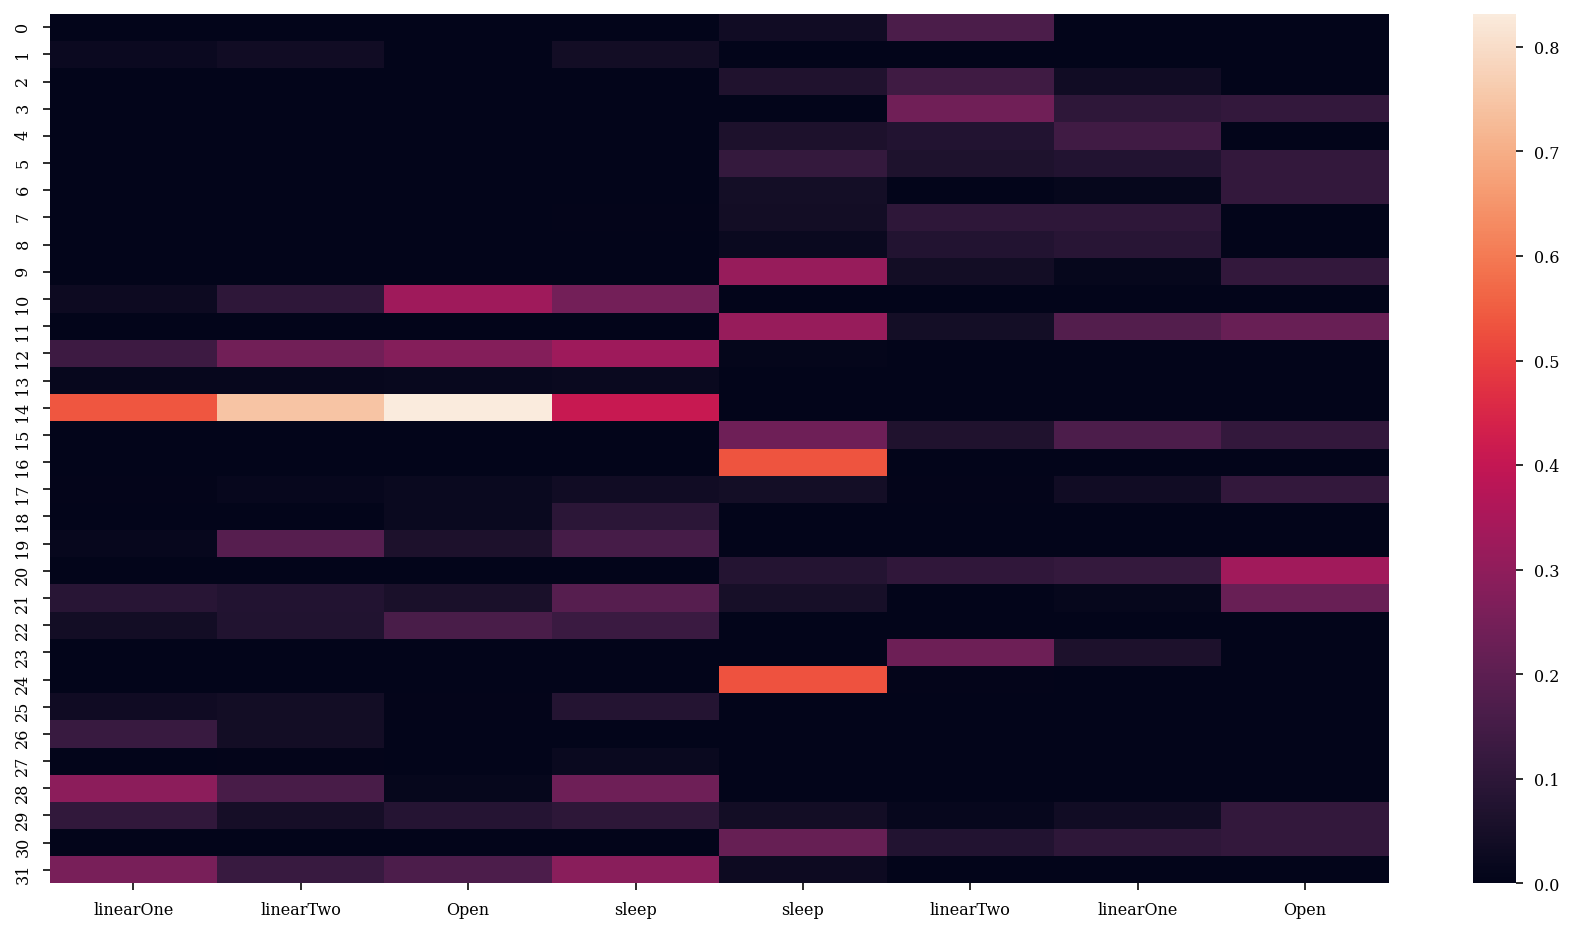

In [59]:
X_df = pd.DataFrame(index = np.arange(X.shape[1]), columns = epoch_name)
X_df[:] = X.T

plt.figure(figsize=(15,8))
sns.heatmap(X_df)